In [18]:
import numpy as np
import os
import argparse
from GridDataGen.utils.io import *
from GridDataGen.utils.process_network import *
from GridDataGen.utils.config import *
from GridDataGen.utils.stats import *
from GridDataGen.utils.param_handler import *
from GridDataGen.utils.load import *
from pandapower.auxiliary import pandapowerNet
import gc
from datetime import datetime
from tqdm import tqdm
from GridDataGen.utils.topology_perturbation import initialize_generator
import psutil
import shutil
import yaml
from GridDataGen.utils.process_network import process_scenario_contingency
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score



# Functions to compute branch current

In [19]:
def compute_branch_currents_kA(Yf, Yt, V, Vf_base_kV, Vt_base_kV, sn_mva):

    
    If_pu = Yf @ V  # From-end currents in per-unit (I_f = Y_f V)
    If_kA = np.abs(If_pu) * sn_mva / (np.sqrt(3) * Vf_base_kV)  # Conversion to kA

    # Construct to-end admittance matrix Yt:
    # Yt[b, :] = y_tf_b * e_f + y_tt_b * e_t
    It_pu = Yt @ V  # To-end currents in per-unit (I_t = Y_t V)
    It_kA = np.abs(It_pu) * sn_mva / (np.sqrt(3) * Vt_base_kV)  # Conversion to kA


    return If_kA, It_kA


def compute_loading(If_kA, It_kA, Vf_base_kV, Vt_base_kV, rate_a):
    """
    Compute per-branch loading using current magnitudes and branch ratings.

    Parameters:
    - edge_index: np.ndarray of shape (n_edges, 2), each row is [from_bus, to_bus]
    - If_kA: np.ndarray of from-side current magnitudes in kA
    - It_kA: np.ndarray of to-side current magnitudes in kA
    - base_kv: np.ndarray of shape (n_buses,), base voltage in kV per bus
    - edge_attr: np.ndarray of shape (n_edges, >=5), edge features, column 4 = RATE_A

    Returns:
    - loading: np.ndarray of shape (n_edges,), max of from and to side loading
    """

    limitf = rate_a / (Vf_base_kV * np.sqrt(3))
    limitt = rate_a / (Vt_base_kV * np.sqrt(3))

    loadingf = If_kA / limitf
    loadingt = It_kA / limitt

    return np.maximum(loadingf, loadingt)

# Load data

In [20]:
# pf_node = pd.read_csv("../../data_contingency/case300_ieee/merged/GridFM_v0.1.2_case300_ieee_output_pf_node.csv")
pf_node= pd.read_csv("../../data_contingency/case300_ieee/merged/Alban_Contingency_GridFM_v0.1.2_case300_ieee_output_pf_node.csv")
branch_idx_removed = pd.read_csv("../../data_contingency/case300_ieee/raw/branch_idx_removed.csv")
edge_params = pd.read_csv("../../data_contingency/case300_ieee/raw/edge_params.csv")
bus_params = pd.read_csv("../../data_contingency/case300_ieee/raw/bus_params.csv")

# Sanity check -> check the RMSE on VA and VM is the same as the one Celia shared on slack

In [21]:
# compute rmse on Va_pred_corrected and va
rmse = np.sqrt(np.mean((pf_node["VA_pred"] - pf_node["Va"])**2))
print(f"RMSE: {rmse}")

# compute rmse on Vm_pred_corrected and vm
rmse = np.sqrt(np.mean((pf_node["VM_pred"] - pf_node["Vm"])**2))
print(f"RMSE: {rmse}")






RMSE: 2.119627621273439
RMSE: 0.04078682162485565


In [22]:
# compute rmse on Va_pred_corrected and va
rmse = np.sqrt(np.mean((pf_node["Va_dc"] - pf_node["Va"])**2))
print(f"RMSE: {rmse}")

# compute rmse on Vm_pred_corrected and vm
rmse = np.sqrt(np.mean((pf_node["Vm_dc"] - pf_node["Vm"])**2))
print(f"RMSE: {rmse}")






RMSE: 15.45816831258575
RMSE: 0.028977134344816018


# Create Admittance matrix

In [23]:
base_kv = bus_params["baseKV"].values
sn_mva = 100

# Extract from-bus and to-bus indices for each branch

f = edge_params["from_bus"].values.astype(np.int32)
t = edge_params["to_bus"].values.astype(np.int32)

# Extract branch admittance coefficients
Yff = edge_params["Yff_r"].values + 1j * edge_params["Yff_i"].values
Yft = edge_params["Yft_r"].values + 1j * edge_params["Yft_i"].values
Ytf = edge_params["Ytf_r"].values + 1j * edge_params["Ytf_i"].values
Ytt = edge_params["Ytt_r"].values + 1j * edge_params["Ytt_i"].values

# Get base voltages for the from and to buses (for kA conversion)
Vf_base_kV = base_kv[f]
Vt_base_kV = base_kv[t]

nl = edge_params.shape[0]
nb = bus_params.shape[0]

# i = [0, 1, ..., nl-1, 0, 1, ..., nl-1], used for constructing Yf and Yt
i = np.hstack([np.arange(nl), np.arange(nl)])

# Construct from-end admittance matrix Yf using the linear combination:
# Yf[b, :] = y_ff_b * e_f + y_ft_b * e_t
Yf = csr_matrix((np.hstack([Yff, Yft]), (i, np.hstack([f, t]))), shape=(nl, nb))
Yt = csr_matrix((np.hstack([Ytf, Ytt]), (i, np.hstack([f, t]))), shape=(nl, nb))

rate_a = edge_params["rate_a"].values

# Correct voltage predictions

In [24]:
pf_node["Vm_pred_corrected"] = pf_node["VM_pred"]
pf_node["Va_pred_corrected"] = pf_node["VA_pred"]

pf_node.loc[pf_node.PV==1, "Vm_pred_corrected"] = pf_node.loc[pf_node.PV==1, "Vm"]
pf_node.loc[pf_node.REF==1, "Va_pred_corrected"] = pf_node.loc[pf_node.REF==1, "Va"]

In [25]:
pf_node["Vm_dc_corrected"] = pf_node["Vm_dc"]
pf_node["Va_dc_corrected"] = pf_node["Va_dc"]

pf_node.loc[pf_node.PV==1, "Vm_dc_corrected"] = pf_node.loc[pf_node.PV==1, "Vm"]
pf_node.loc[pf_node.REF==1, "Va_dc_corrected"] = pf_node.loc[pf_node.REF==1, "Va"]

In [26]:
# compute rmse on Va_pred_corrected and va
rmse = np.sqrt(np.mean((pf_node["Va_dc_corrected"] - pf_node["Va"])**2))
print(f"RMSE: {rmse}")

# compute rmse on Vm_pred_corrected and vm
rmse = np.sqrt(np.mean((pf_node["Vm_dc_corrected"] - pf_node["Vm"])**2))
print(f"RMSE: {rmse}")






RMSE: 15.45816831258575
RMSE: 0.02838646359403712


# Compute branch current and loading

In [27]:
loadings = []
loadings_pred = []
loadings_dc = []

for scenario_idx in tqdm(pf_node.scenario.unique()):
    pf_node_scenario = pf_node[pf_node.scenario == scenario_idx]
    branch_idx_removed_scenario = branch_idx_removed[branch_idx_removed.scenario == scenario_idx].iloc[:, 1:].values
    # remove nan
    branch_idx_removed_scenario = branch_idx_removed_scenario[~np.isnan(branch_idx_removed_scenario)].astype(np.int32)
    V_true = pf_node_scenario["Vm"].values * np.exp(1j * pf_node_scenario["Va"].values * np.pi / 180)
    V_pred = pf_node_scenario["Vm_pred_corrected"].values * np.exp(1j * pf_node_scenario["Va_pred_corrected"].values * np.pi / 180)
    V_dc = pf_node_scenario["Vm_dc_corrected"].values * np.exp(1j * pf_node_scenario["Va_dc_corrected"].values * np.pi / 180)
    If_true, It_true = compute_branch_currents_kA(Yf, Yt, V_true, Vf_base_kV, Vt_base_kV, sn_mva)
    If_pred, It_pred = compute_branch_currents_kA(Yf, Yt, V_pred, Vf_base_kV, Vt_base_kV, sn_mva)
    If_dc, It_dc = compute_branch_currents_kA(Yf, Yt, V_dc, Vf_base_kV, Vt_base_kV, sn_mva)

    loading_true = compute_loading(If_true, It_true, Vf_base_kV, Vt_base_kV, rate_a)
    loading_pred = compute_loading(If_pred, It_pred, Vf_base_kV, Vt_base_kV, rate_a)
    loading_dc = compute_loading(If_dc, It_dc, Vf_base_kV, Vt_base_kV, rate_a)

    # remove the branches that are removed from loading
    loading_true[branch_idx_removed_scenario] = -1
    loading_pred[branch_idx_removed_scenario] = -1
    loading_dc[branch_idx_removed_scenario] = -1

    loadings.append(loading_true)
    loadings_pred.append(loading_pred)
    loadings_dc.append(loading_dc)


loadings = np.array(loadings)
loadings_pred = np.array(loadings_pred)
loadings_dc = np.array(loadings_dc)

    

    

100%|██████████| 10230/10230 [00:26<00:00, 383.66it/s]


In [28]:
removed_lines = (loadings == -1)
removed_lines_pred = (loadings_pred == -1)
removed_lines_dc = (loadings_dc == -1)


# assert the same lines are removed
assert (removed_lines == removed_lines_pred).all()
assert (removed_lines == removed_lines_dc).all()


# assert the same number of lines are removed
assert (removed_lines.sum() == removed_lines_pred.sum())
assert (removed_lines.sum() == removed_lines_dc.sum())




# Compute overloadings

In [29]:
overloadings = loadings[removed_lines==False] > 1
overloadings_pred = (loadings_pred[removed_lines==False] > 0.95)
overloadings_dc = (loadings_dc[removed_lines==False] > 0.95)


# Compute TPR, FPR, TNR, FNR for GridFM

- Below are the results of GridFM for overloading classification (GNN version, not transformer, finetuned on PF for IEEE300, and later finetuned on Contingency Data)
- Ground truth is AC PF.
- We use a threshold of 0.95 to make sure we identify all overloads

In [30]:
TPR = (overloadings & overloadings_pred).sum() / overloadings.sum()
FPR = ((~overloadings) & overloadings_pred).sum() / (~overloadings).sum()
TNR = ((~overloadings) & ~overloadings_pred).sum() / (~overloadings).sum()
FNR = (overloadings & ~overloadings_pred).sum() / overloadings.sum()

print(f"GridFM: TPR: {TPR:.3f}, FPR: {FPR:.3f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")



GridFM: TPR: 0.975, FPR: 0.007, TNR: 0.99, FNR: 0.02


- Below are the results of DC PF for overloading classification
- Ground truth is AC PF.
- We use a threshold of 0.95 to make sure we identify all overloads

In [31]:
TPR = (overloadings & overloadings_dc).sum() / overloadings.sum()
FPR = ((~overloadings) & overloadings_dc).sum() / (~overloadings).sum()
TNR = ((~overloadings) & ~overloadings_dc).sum() / (~overloadings).sum()
FNR = (overloadings & ~overloadings_dc).sum() / overloadings.sum()

print(f"DC: TPR: {TPR:.3f}, FPR: {FPR:.3f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")



DC: TPR: 0.986, FPR: 0.007, TNR: 0.99, FNR: 0.01


# Find best threshold for classification for GridFM

In [32]:
best_thresh = 0.0
best_f1 = 0.0
thresholds = np.linspace(0.7, 1, 31)

for thresh in tqdm(thresholds):
    y_pred = (loadings_pred[removed_lines==False] >= thresh)
    f1 = f1_score(overloadings, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh}, Best F1: {best_f1}")

100%|██████████| 31/31 [00:10<00:00,  3.06it/s]

Best threshold: 0.99, Best F1: 0.6971082658305026


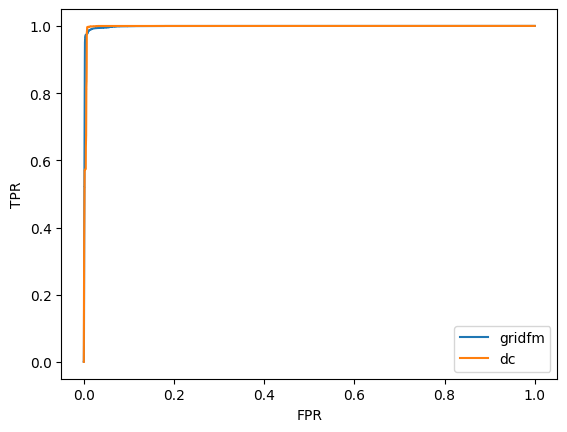

In [33]:

from sklearn.metrics import roc_curve
fpr_gridfm, tpr_gridfm, thresholds_gridfm = roc_curve(overloadings, loadings_pred[removed_lines==False])
fpr_dc, tpr_dc, thresholds_dc = roc_curve(overloadings, loadings_dc[removed_lines==False])
plt.plot(fpr_gridfm, tpr_gridfm, label="gridfm")
plt.plot(fpr_dc, tpr_dc,  label="dc")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


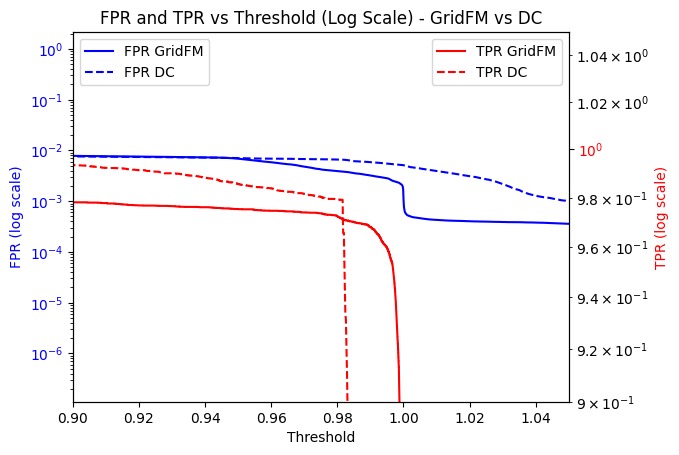

In [34]:

# Plot FPR on a log scale
fig, ax1 = plt.subplots()

ax1.plot(thresholds_gridfm, fpr_gridfm, label="FPR GridFM", color='blue')
ax1.plot(thresholds_dc, fpr_dc, label="FPR DC", color='blue', linestyle='--')
ax1.set_xlabel("Threshold")
ax1.set_ylabel("FPR (log scale)", color='blue')
ax1.set_yscale('log')  # log scale for FPR
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlim(0.90, 1.05)

# Create a second y-axis for TPR
ax2 = ax1.twinx()
ax2.plot(thresholds_gridfm, tpr_gridfm, label="TPR GridFM", color='red')
ax2.plot(thresholds_dc, tpr_dc, label="TPR DC", color='red', linestyle='--')
ax2.set_ylabel("TPR (log scale)", color='red')
ax2.set_yscale('log')  # log scale for TPR
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0.90, 1.05)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("FPR and TPR vs Threshold (Log Scale) - GridFM vs DC")
plt.show()

# Plot histogram of true loadings



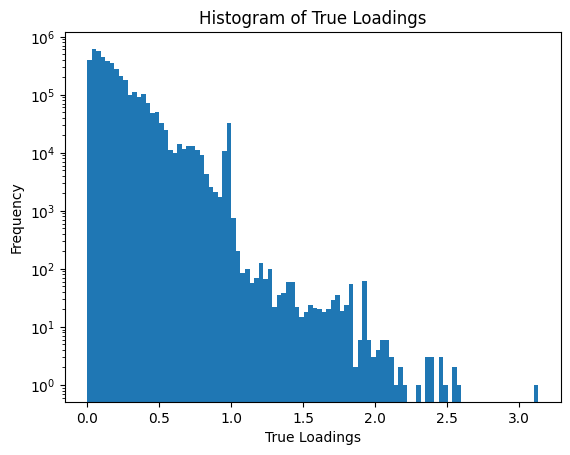

In [35]:
plt.hist(loadings[removed_lines==False], bins=100)
plt.xlabel("True Loadings")
plt.ylabel("Frequency")
plt.title("Histogram of True Loadings")
# log scale
plt.yscale("log")
plt.savefig("loadings_histogram.png")
plt.show()



# Plot pred vs true loadings

/var/folders/ld/19f7b26x5s9771w9ggsv_vxh0000gn/T/ipykernel_42161/3708744735.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("scatter_loading.png")
/Users/albanpuech/grid_data_synthetic/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


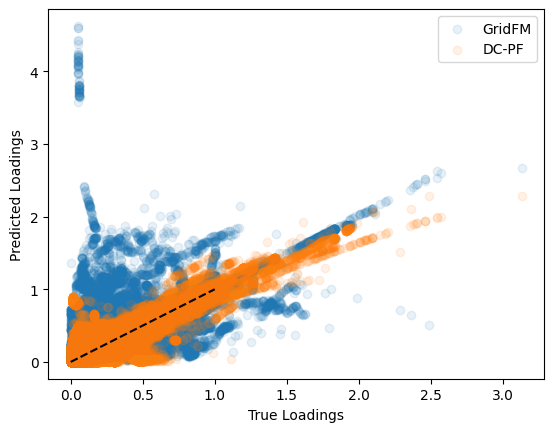

In [38]:
# scatter plot of loadings and loadings_pred
plt.scatter(loadings[removed_lines==False], loadings_pred[removed_lines==False], alpha=0.1, label="GridFM")
plt.scatter(loadings[removed_lines==False], loadings_dc[removed_lines==False], alpha=0.1, label="DC-PF")
plt.xlabel("True Loadings")
plt.ylabel("Predicted Loadings")
# plot the line y=x
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.savefig("scatter_loading.png")
plt.show()



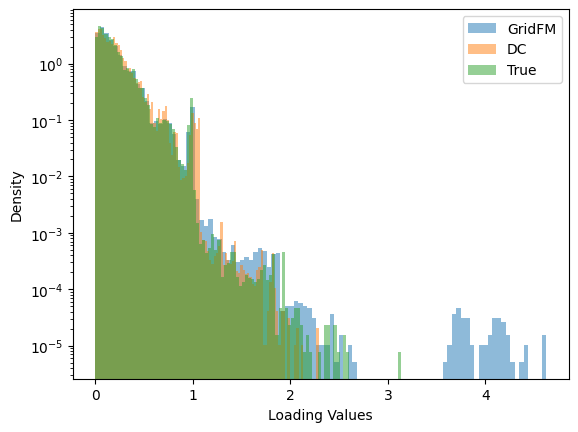

In [71]:
# Histograms of loadings
plt.hist(loadings_pred[removed_lines==False], alpha=0.5, label="GridFM", density=True, bins=100)
plt.hist(loadings_dc[removed_lines==False], alpha=0.5, label="DC", density=True, bins=100)
plt.hist(loadings[removed_lines==False], alpha=0.5, label="True", density=True, bins=100)

plt.xlabel("Loading Values")
plt.ylabel("Density")
plt.yscale("log")

plt.legend()
plt.show()

In [72]:
# create df from loadings
loadings_df = pd.DataFrame(loadings)
loadings_df.columns = [f"branch_{i}" for i in range(loadings_df.shape[1])]

loadings_pred_df = pd.DataFrame(loadings_pred)
loadings_pred_df.columns = [f"branch_{i}" for i in range(loadings_pred_df.shape[1])]


In [83]:
loadings_df['scenario'] = pf_node['scenario'].unique()
loadings_pred_df['scenario'] = pf_node['scenario'].unique()

# Plot loading predictions at every bus (takes about 30 seconds)

In [20]:
# # Calculate grid dimensions
# n_branches = loadings.shape[1]
# n_cols = 4  # You can adjust this to change the number of columns
# n_rows = (n_branches + n_cols - 1) // n_cols  # Ceiling division

# # Create figure with subplots
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
# axes = axes.flatten()

# # Plot each bus
# for i in range(n_branches):
#     ax = axes[i]
#     ax.scatter(loadings[:, i], loadings_pred[:, i], alpha=0.1, s=10)
#     ax.set_xlabel("True")
#     ax.set_ylabel("Pred")
#     ax.set_title(f"Branch {i+1}")
    
#     # Set equal aspect ratio
#     ax.set_aspect('equal')
    
#     # Set same limits for x and y
#     max_val = max(loadings[:, i].max(), loadings_pred[:, i].max())
#     min_val = min(loadings[:, i].min(), loadings_pred[:, i].min())
#     ax.set_xlim(min_val, max_val)
#     ax.set_ylim(min_val, max_val)
    
#     # Add diagonal line
#     ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)

# # Hide unused subplots
# for i in range(n_branches, len(axes)):
#     axes[i].set_visible(False)

# plt.tight_layout()
# plt.show()


# Voltage violations

In [50]:
# merge bus_params["vmax"] and bus_params["vmin"] with pf_node on bus_idx
pf_node = pd.merge(pf_node, bus_params[["bus", "vmax", "vmin"]], on="bus", how="left")


In [51]:
# check violations of vmax and vmin with Vm_pred_corrected and Vm
voltage_violations = (pf_node["Vm"] > pf_node["vmax"]) | (pf_node["Vm"] < pf_node["vmin"])
voltage_violations_pred = (pf_node["Vm_pred_corrected"] > pf_node["vmax"]-0.01) | (pf_node["Vm_pred_corrected"] < pf_node["vmin"]+0.01)
voltage_violations_dc = (pf_node["Vm_dc_corrected"] > pf_node["vmax"]-0.01) | (pf_node["Vm_dc_corrected"] < pf_node["vmin"]+0.01)



- Below are the results of GridFM for voltage magnitude violations (GNN version, not transformer, finetuned on PF for IEEE300, and later finetuned on Contingency Data)
- Ground truth is AC PF.
- We use add a safety margin of 0.01 pu to make sure we identify all voltage violations

In [ ]:

# compute TPR, FPR, TNR, FNR
TPR = (voltage_violations & voltage_violations_pred).sum() / voltage_violations.sum()
FPR = (voltage_violations & (~voltage_violations_pred)).sum() / (~voltage_violations).sum()
TNR = (~voltage_violations & ~voltage_violations_pred).sum() / (~voltage_violations).sum()
FNR = (voltage_violations & (~voltage_violations_pred)).sum() / voltage_violations.sum()

print(f"TPR: {TPR:.2f}, FPR: {FPR:.4f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")

TPR: 0.97, FPR: 0.0004, TNR: 0.80, FNR: 0.03


In [52]:

# compute TPR, FPR, TNR, FNR
TPR = (voltage_violations & voltage_violations_dc).sum() / voltage_violations.sum()
FPR = (voltage_violations & (~voltage_violations_dc)).sum() / (~voltage_violations).sum()
TNR = (~voltage_violations & ~voltage_violations_dc).sum() / (~voltage_violations).sum()
FNR = (voltage_violations & (~voltage_violations_dc)).sum() / voltage_violations.sum()

print(f"TPR: {TPR:.2f}, FPR: {FPR:.4f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")

TPR: 0.07, FPR: 0.0147, TNR: 0.90, FNR: 0.93


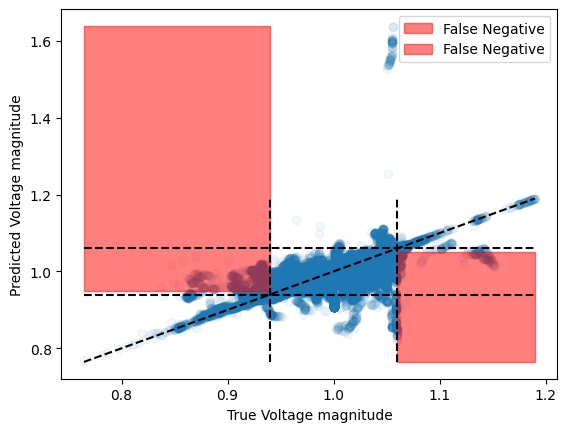

In [39]:
# scatter plot of Va_pred_corrected and va
plt.scatter(pf_node["Vm"], pf_node["Vm_pred_corrected"], alpha=0.05)
plt.xlabel("True Voltage magnitude")
plt.ylabel("Predicted Voltage magnitude")
# get max and min of pf_node["Vm"] and pf_node["Vm_pred_corrected"]
max_vm = pf_node["Vm"].max()
min_vm = pf_node["Vm"].min()
max_vm_pred = pf_node["Vm_pred_corrected"].max()
min_vm_pred = pf_node["Vm_pred_corrected"].min()

# plot y=x
plt.plot([min_vm, max_vm], [min_vm, max_vm], 'k--')
# plot y = 0.94
plt.plot([min_vm, max_vm], [0.94, 0.94], 'k--')
plt.plot([min_vm, max_vm], [1.06, 1.06], 'k--')
# plot the line x = 0.94
plt.plot([0.94, 0.94], [min_vm, max_vm], 'k--')
# plot the line x = 1.06
plt.plot([1.06, 1.06], [min_vm, max_vm], 'k--')
# plot areas where x < 0.94 but y > 0.94
plt.fill_between([min_vm, 0.94], [0.95, 0.95], [max_vm_pred, max_vm_pred], color='red', alpha=0.5, label='False Negative')
# plot areas where x > 1.06 but y < 1.06
plt.fill_between([1.06, max_vm], [1.05, 1.05], [min_vm, min_vm], color='red', alpha=0.5, label='False Negative')

plt.legend()
plt.savefig("scatter_voltage.png")
plt.show()



# find best threshold for voltage violations

In [24]:
best_thresh = 0.0
best_f1 = 0.0
thresholds = np.linspace(-0.05, 0.05, 20)

for thresh in tqdm(thresholds):
    voltage_violations_pred = (pf_node["Vm_pred_corrected"] > pf_node["vmax"]-thresh) | (pf_node["Vm_pred_corrected"] < pf_node["vmin"]+thresh)
    f1 = f1_score(voltage_violations, voltage_violations_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh}, Best F1: {best_f1}")

100%|██████████| 20/20 [00:09<00:00,  2.21it/s]

Best threshold: 0.0026315789473684154, Best F1: 0.2106450778228711


In [25]:
# # Group by bus
# grouped_pf_node = pf_node.groupby("bus")
# buses = list(grouped_pf_node.groups.keys())
# n_buses = len(buses)

# # Grid dimensions
# n_cols = 4  # Adjust as needed
# n_rows = (n_buses + n_cols - 1) // n_cols  # Ceiling division

# # Create subplots
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
# axes = axes.flatten()

# # Plot for each bus
# for i, bus in enumerate(buses):
#     group = grouped_pf_node.get_group(bus)
#     ax = axes[i]
    
#     ax.scatter(group["Vm"], group["Vm_pred_corrected"], alpha=0.1, s=10)
#     ax.set_xlabel("True")
#     ax.set_ylabel("Pred")
#     ax.set_title(f"Bus {bus}")
#     ax.set_aspect("equal")

#     min_val = min(group["Vm"].min(), group["Vm_pred_corrected"].min())
#     max_val = max(group["Vm"].max(), group["Vm_pred_corrected"].max())
#     ax.set_xlim(min_val, max_val)
#     ax.set_ylim(min_val, max_val)
#     ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# # Hide unused subplots
# for i in range(n_buses, len(axes)):
#     axes[i].set_visible(False)

# plt.tight_layout()
# plt.show()